In [ ]:
import pandas as pd
from google.colab import drive
from sklearn.linear_model import BayesianRidge
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, accuracy_score

In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/data.csv'
# Load the dataset

data = pd.read_csv(file_path)
data=data[['TRANS DATE','MERCHANT NAME', 'CARD NUMBER', 'ORIGINAL GROSS AMT']]

#data= data[data['ORIGINAL GROSS AMT'] < 500]
data= data[data['ORIGINAL GROSS AMT'] > 0]

# Drop rows with any remaining missing values
data['TRANS DATE']=pd.to_datetime(data['TRANS DATE'], errors='coerce')
data_cleaned = data.dropna()

# Convert 'TRANS DATE' to datetime format and handle missing values in 'MERCHANT NAME'
data['TRANS DATE'] = pd.to_datetime(data['TRANS DATE'], errors='coerce')
data= data.loc[data['TRANS DATE']>'01-01-2020']
data['MERCHANT NAME'] = data['MERCHANT NAME'].fillna('Unknown')
data2=data.copy()
Q1 = data['ORIGINAL GROSS AMT'].quantile(0.25)
Q3 = data['ORIGINAL GROSS AMT'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
data= data[(data['ORIGINAL GROSS AMT'] >= lower_bound) & (data['ORIGINAL GROSS AMT'] <= upper_bound)]

data['P ORIGINAL GROSS AMT'] = data.groupby('CARD NUMBER')['ORIGINAL GROSS AMT'].shift(1)
data['P TRANS DATE'] = data.groupby('CARD NUMBER')['TRANS DATE'].shift(1)
# Drop rows with any remaining missing values
data_cleaned = data.dropna().copy()

# Feature Engineering: Create time-related features
data_cleaned['P_YEAR'] = data_cleaned['P TRANS DATE'].dt.year
data_cleaned['P_MONTH'] = data_cleaned['P TRANS DATE'].dt.month
data_cleaned['P_DAY'] = data_cleaned['P TRANS DATE'].dt.day
data_cleaned['P_DAY_OF_WEEK'] = data_cleaned['P TRANS DATE'].dt.dayofweek
data_cleaned = data_cleaned.dropna()#.copy()

# Encode the categorical variable MERCHANT NAME
le_merchant = LabelEncoder()
data_cleaned['MERCHANT NAME'] = le_merchant.fit_transform(data_cleaned['MERCHANT NAME'])
data_cleaned['P MERCHANT NAME'] = data_cleaned.groupby('CARD NUMBER')['MERCHANT NAME'].shift(1)
data_cleaned = data_cleaned.dropna()

# Splitting data into features and target variables
unique_card_numbers = data_cleaned['CARD NUMBER'].unique()
train_list = []
test_list = []

for card_number, group in data_cleaned.groupby('CARD NUMBER'):
    # Determine the number of rows that will go into the test set (last 20%)
    n_test = int(len(group) * 0.2)

    # Split the group into train and test
    train_list.append(group.iloc[:-n_test])  # All except the last 20%
    test_list.append(group.iloc[-n_test:])   # Last 20%

# Concatenate all the train and test groups into two DataFrames
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

train_list = []
test_list = []

for card_number, group in data_cleaned.groupby('CARD NUMBER'):
    # Determine the number of rows that will go into the test set (last 20%)
    n_test = int(len(group) * 0.2)

    # Ensure at least one sample is included in the test set if there are enough rows
    if n_test == 0 and len(group) > 1:
        n_test = 1

    # Split the group into train and test
    if n_test > 0:
        train_list.append(group.iloc[:-n_test])  # All except the last 20%
        test_list.append(group.iloc[-n_test:])   # Last 20%
    else:
        train_list.append(group)  # If n_test is 0, put all data in the training set

# Concatenate all the train and test groups into two DataFrames
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

# Reset index if needed
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

X_amt_train=train_df.drop(columns=['TRANS DATE', 'ORIGINAL GROSS AMT','MERCHANT NAME','P TRANS DATE'])
X_amt_test=test_df.drop(columns=['TRANS DATE', 'ORIGINAL GROSS AMT','MERCHANT NAME','P TRANS DATE'])
y_amt_test=test_df['ORIGINAL GROSS AMT'].values
y_amt_train=train_df['ORIGINAL GROSS AMT'].values

print(X_amt_train.shape)
print(X_amt_test.shape)
print(y_amt_test.shape)
print(y_amt_train.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(30367, 7)
(7562, 7)
(7562,)
(30367,)


bayesain ridge

In [ ]:
# Train Bayesian Ridge Regression for predicting the amount
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
import numpy as np

# Feature columns that need to be normalized
feature_columns = ['P ORIGINAL GROSS AMT','P_YEAR', 'P_MONTH', 'P_DAY', 'P_DAY_OF_WEEK']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_amt_train[feature_columns] = scaler.fit_transform(X_amt_train[feature_columns])

# Transform the test data using the same scaler
X_amt_test[feature_columns] = scaler.transform(X_amt_test[feature_columns])

# Now you can proceed with fitting the Bayesian Ridge model
model = BayesianRidge()
model.fit(X_amt_train, y_amt_train)

# Make predictions
y_amt_pred = model.predict(X_amt_test)

# Evaluate the model
mse = mean_squared_error(y_amt_test, y_amt_pred)
print(f"Mean Squared Error: {mse}")
param_dist = {
    'alpha_1': np.logspace(-3, 2, 6),
    'alpha_2': np.logspace(-3, 2, 6),
    'lambda_1': np.logspace(-3, 2, 6)   #
    ,'lambda_2': np.logspace(-3, 2, 6)#[1e-6, 1e-4, 1e-2, 1]
}
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_amt_train, y_amt_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Best model
best_model = random_search.best_estimator_

# Predict and evaluate with the best model
y_amount_pred = best_model.predict(X_amt_test)
y_amount_pred_train= best_model.predict(X_amt_train)
# Predict on the test set

# Evaluate the model for amount prediction
mse_amount = mean_squared_error(y_amt_test, y_amount_pred)
mae_amount = mean_absolute_error(y_amt_test, y_amount_pred)
mse_amount_train = mean_squared_error(y_amt_train, y_amount_pred_train)
mae_amount_train = mean_absolute_error(y_amt_train, y_amount_pred_train)
rsme_amount = mean_squared_error(y_amt_test, y_amount_pred, squared=False)
rsme_amount_train = mean_squared_error(y_amt_train, y_amount_pred_train, squared=False)

print(f'Amount Prediction MAE: {mae_amount:.4f}')
print(f'Amount Prediction MsE: {mse_amount:.4f}')
print(f'Amount Prediction MAE Train: {mae_amount_train:.4f}')
print(f'Amount Prediction MsE Train: {mse_amount_train:.4f}')
print(f'Amount Prediction RMSE: {rsme_amount:.4f}')
print(f'Amount Prediction RMSE Train: {rsme_amount_train :.4f}')

Mean Squared Error: 1946.916258492254
Best Parameters: {'lambda_2': 100.0, 'lambda_1': 0.01, 'alpha_2': 0.1, 'alpha_1': 1.0}
Amount Prediction MAE: 34.4500
Amount Prediction MsE: 1946.8843
Amount Prediction MAE Train: 33.7493
Amount Prediction MsE Train: 1968.6220
Amount Prediction RMSE: 44.1235
Amount Prediction RMSE Train: 44.3692


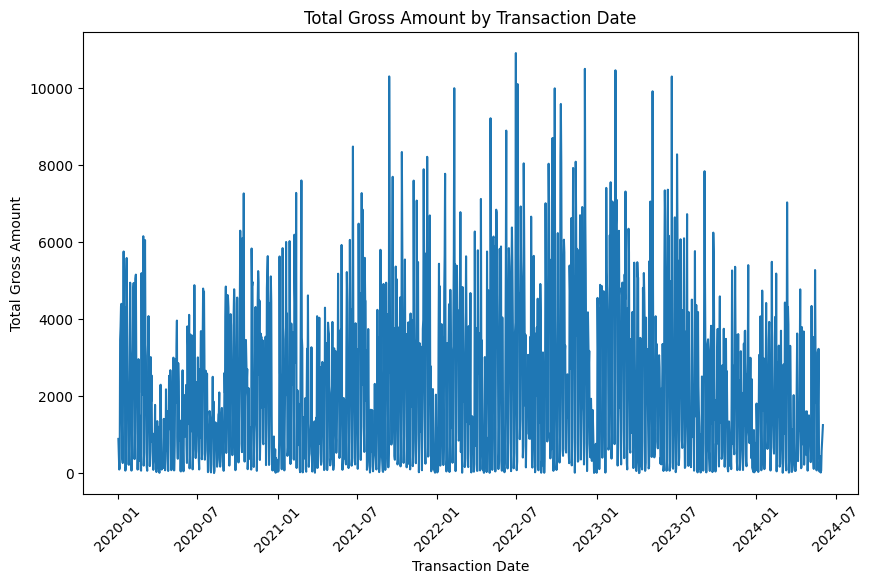

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
grouped_data = data2.groupby('TRANS DATE')['ORIGINAL GROSS AMT'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(grouped_data['TRANS DATE'], grouped_data['ORIGINAL GROSS AMT'])
plt.title('Total Gross Amount by Transaction Date')
plt.xlabel('Transaction Date')
plt.ylabel('Total Gross Amount')
plt.xticks(rotation=45)
plt.show()

bayeasin linear regression

In [ ]:
import pymc as pm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare the data
X_train = X_amt_train.values
X_test = X_amt_test.values
y_train = y_amt_train

# Define the Bayesian Linear Regression model using PyMC3
with pm.Model() as linear_model:
    # Priors for the coefficients
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    betas = pm.Normal('betas', mu=0, sigma=10, shape=X_train.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model
    mu = alpha + pm.math.dot(X_train, betas)

    # Likelihood
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_train)

    # Sampling from the posterior
    trace = pm.sample(1000, return_inferencedata=False, tune=1000, cores=2)

# Use the trained model to make predictions on the test set
with linear_model:
    # Explicitly define the deterministic prediction
    mu_test = trace['alpha'][:, None] + np.dot(trace['betas'], X_test.T)
    y_pred_bayesian = mu_test.mean(axis=0)

# Calculate evaluation metrics
mse_bayesian = mean_squared_error(y_amt_test, y_pred_bayesian)
mae_bayesian = mean_absolute_error(y_amt_test, y_pred_bayesian)
rsme_bayesian = mean_squared_error(y_amt_test, y_pred_bayesian, squared=False)

with linear_model:
    # Prediction on training data
    mu_train = trace['alpha'][:, None] + np.dot(trace['betas'], X_train.T)
    y_pred_bayesian_train = mu_train.mean(axis=0)

mse_bayesian_train = mean_squared_error(y_amt_train, y_pred_bayesian_train)
mae_bayesian_train = mean_absolute_error(y_amt_train, y_pred_bayesian_train)
rsme_bayesian_train = mean_squared_error(y_amt_train, y_pred_bayesian_train, squared=False)

print("MSE (Bayesian Linear Regression):", mse_bayesian)
print("MAE (Bayesian Linear Regression):", mae_bayesian)
print("RMSE (Bayesian Linear Regression):", rsme_bayesian)
print("MSE (Bayesian Linear Regression) Train:", mse_bayesian_train)
print("MAE (Bayesian Linear Regression) Train:", mae_bayesian_train)
print("RMSE (Bayesian Linear Regression) Train:", rsme_bayesian_train)

MSE (Bayesian Linear Regression): 1946.473805839155
MAE (Bayesian Linear Regression): 34.434717152727096
RMSE (Bayesian Linear Regression): 44.11885997891554
MSE (Bayesian Linear Regression) Train: 1968.626692847813
MAE (Bayesian Linear Regression) Train: 33.73586243832377
RMSE (Bayesian Linear Regression) Train: 44.369208837298565
